---
title: Exploratory data analysis
description: ...
---

### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

sns.set_theme(style = 'ticks', palette = 'pastel')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.bbox'] = 'tight'
# Remove comment for saving figures
sns.set_context("paper")
# Define fig saving context
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.directory'] = 'figures'

import numpy as np
from IPython.display import display, Markdown

from datetime import datetime

from utils.utils import filter_team, league_team, team_league, unique_teams, unique_teams_coach_change
# league_team : league -> [team]
# team_league : team -> league
# unique_teams : [all teams]
# unique_teams_coach_change : [all teams that have had a coach change]

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

/var/folders/7l/wwrkhf0515x8dl_scksshbc00000gn/T/ipykernel_41574/3700662385.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading data

In [2]:
match_results = pd.read_csv('data/match_results.csv', parse_dates=['date'])
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['appointed', 'end_date'])

match_results.head()

,league,country,season_year,date,home,home_goals,away,away_goals
0,Premier League,England,2018,2017-08-11,Arsenal,4.0,Leicester City,3.0
1,Premier League,England,2018,2017-08-12,Watford,3.0,Liverpool,3.0
2,Premier League,England,2018,2017-08-12,Crystal Palace,0.0,Huddersfield,3.0
3,Premier League,England,2018,2017-08-12,West Brom,1.0,Bournemouth,0.0
4,Premier League,England,2018,2017-08-12,Chelsea,2.0,Burnley,3.0


In [3]:
# General information
min_year = match_results['date'].min()
max_year = match_results['date'].max()

### General information about data

Data collected from match results ranges from {eval}`min_year.strftime("%m/%d/%Y")` to {eval}`max_year.strftime("%m/%d/%Y")` and contains the results of {eval}`len(match_results)` matches.

Matches have been collected for the following leagues : **{eval}`", ".join(match_results['league'].unique().tolist())`**

In [18]:
# Leagues informations
match_results['total_goals'] = match_results['home_goals'] + match_results['away_goals']
leagues = (match_results.groupby(['league', 'country'])
            .agg(matches_played=('home', 'count'), avg_goals=('total_goals', 'mean'))
            .reset_index()
            .assign(league_country=lambda df: df['league'] + ' (' + df['country'] + ')')
            .sort_values(by='matches_played', ascending=False))
# Number of teams : use league_team = {league: [team]} to get the number of teams in each league and add it to league dataframe
leagues['number_of_teams'] = leagues['league'].apply(lambda x: len(league_team[x]))

league_team_coach_change = {league: [team for team in league_team[league] if team in unique_teams_coach_change] for league in league_team}
leagues['number_of_teams_with_coach_change'] = leagues['league'].apply(lambda x: len(league_team_coach_change[x]))
# Round avg goals
leagues['avg_goals'] = leagues['avg_goals'].round(2)
# Drop league and country columns
leagues = leagues.drop(columns=['league', 'country'])
leagues = leagues.set_index('league_country')
# Rename columns with proper formatting
leagues = leagues.rename(columns={'matches_played': 'Number of match played', 'avg_goals': 'Average goals', 'number_of_teams': 'Number of teams', 'number_of_teams_with_coach_change': 'Number of teams with coach change'})
# Reorder columns
leagues = leagues[['Number of match played', 'Average goals', 'Number of teams', 'Number of teams with coach change']]
# Rename index
leagues.index.name = 'Leagues'
display(leagues)

,Number of match played,Average goals,Number of teams,Number of teams with coach change
Leagues,,,,
Ligue 1 (France),1908,2.68,28,12
La Liga (Spain),1900,2.55,28,14
Premier League (England),1900,2.75,28,15
Serie A (Italy),1900,2.86,28,16
Bundesliga (Germany),1540,3.06,27,13


In [5]:
for team in unique_teams:
    if filter_team(team).shape[0] != filter_team(team).drop_duplicates().shape[0]:
        print(f"Team {team} has more than one match in the same day")
# No team played more than one match in the same day (ie. date can be index for a team)

### Basic plots

In [6]:
# Useful to add xtick months to dayofyear plot
months = pd.date_range('2022-01-01', '2022-12-31', freq='M').strftime('%b').tolist()
days = np.linspace(1, 365, num=12, dtype=int)

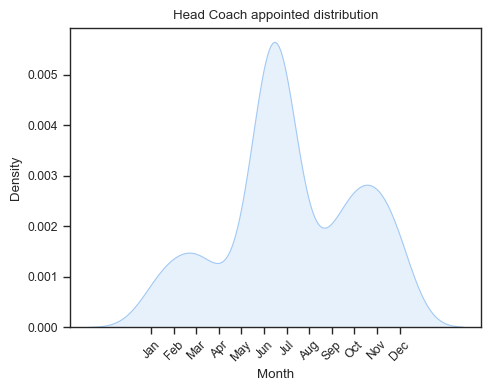

In [7]:
# Head Coach appointed distribution
plt.figure(figsize=(5, 4))
sns.kdeplot(head_coach['appointed'].dt.dayofyear, fill=True)
plt.xticks(days, months, rotation=45)
plt.title('Head Coach appointed distribution')
plt.xlabel('Month');
plt.savefig('figures/head_coach_appointed_distribution.png')

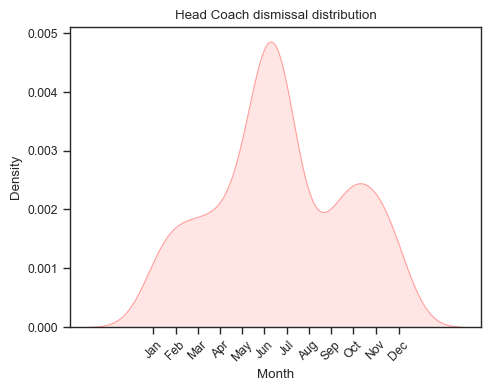

In [8]:
# Head Coach dismissal distribution
plt.figure(figsize=(5, 4))
sns.kdeplot(head_coach['end_date'].dt.dayofyear, fill=True, color = 'r')
plt.xticks(days, months, rotation=45)
plt.title('Head Coach dismissal distribution')
plt.xlabel('Month')
plt.savefig('figures/head_coach_dismissal_distribution.png')

Question intéressante : le fait que le coach soit changé en dehors des dates conventionnelle (juillet) est il une information significative quand à la performance de l'équipe

En moyenne sur les données observées les coachs restent en poste 630 jours.


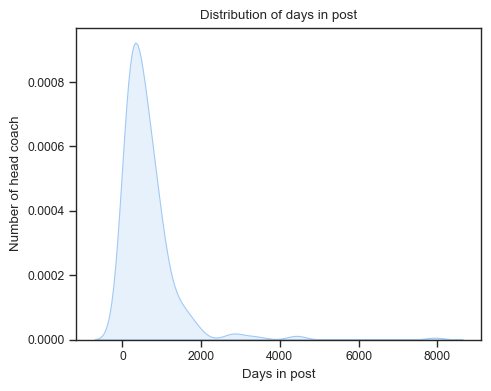

In [9]:
# Plot distribution of head_coach['days_in_post'] 
plt.figure(figsize=(5, 4))
sns.kdeplot(head_coach['days_in_post'], fill=True)
plt.title('Distribution of days in post')
plt.xlabel('Days in post')
plt.ylabel('Number of head coach')
plt.savefig('figures/days_in_post_distribution.png')

print(f"En moyenne sur les données observées les coachs restent en poste {round(head_coach['days_in_post'].mean())} jours.")

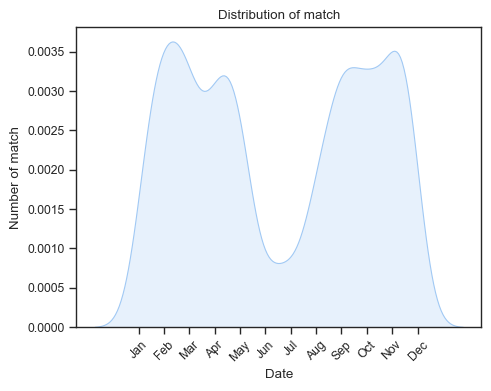

In [10]:
# Plot distribution of match 
plt.figure(figsize=(5, 4))
sns.kdeplot(match_results['date'].dt.dayofyear, fill = True)
plt.title('Distribution of match')
plt.xlabel('Date')
plt.ylabel('Number of match')
plt.xticks(days, months, rotation=45)
plt.savefig('figures/match_distribution.png')

In [11]:
match_results.head()

,league,country,season_year,date,home,home_goals,away,away_goals,total_goals
0,Premier League,England,2018,2017-08-11,Arsenal,4.0,Leicester City,3.0,7.0
1,Premier League,England,2018,2017-08-12,Watford,3.0,Liverpool,3.0,6.0
2,Premier League,England,2018,2017-08-12,Crystal Palace,0.0,Huddersfield,3.0,3.0
3,Premier League,England,2018,2017-08-12,West Brom,1.0,Bournemouth,0.0,1.0
4,Premier League,England,2018,2017-08-12,Chelsea,2.0,Burnley,3.0,5.0


In [12]:
total_matches = match_results.shape[0]
home_goals = match_results['home_goals'].mean()
away_goals = match_results['away_goals'].mean()
diff_goal_perc = ((home_goals - away_goals) / away_goals) * 100

home_win = (match_results['home_goals'] > match_results['away_goals']).sum()
away_win = (match_results['home_goals'] < match_results['away_goals']).sum()
diff_win_perc = ((home_win - away_win) / away_win) * 100

draw_count = (match_results['home_goals'] == match_results['away_goals']).sum()
draw_perc = (draw_count / (home_win + away_win)) * 100

{eval}`f"In average, team playing at home scored {home_goals:.2f} goals while away team scored {away_goals:.2f} goals ({+ diff_goal_perc:.0f} % more goals)."`

{eval}`f"This resulted in {home_win} matches won by team playing at home vs {away_win} for the team playing away ({diff_win_perc:.0f} % more wins)"`

{eval}`f"{draw_count} matches resulted in a draw ({draw_perc:.0f} %)"`

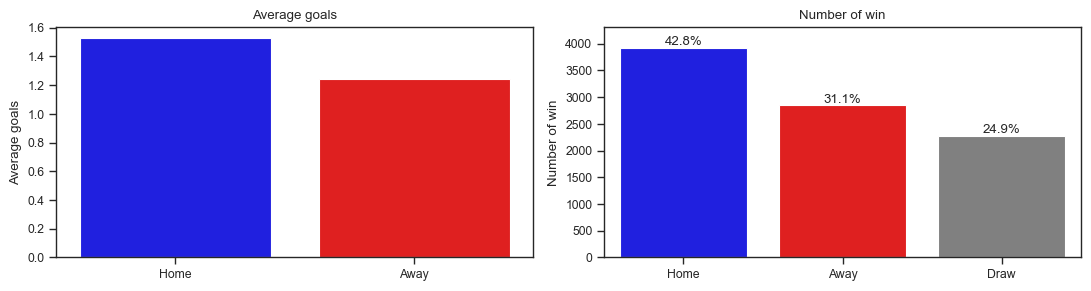

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))

sns.barplot(x=['Home', 'Away'], y=[home_goals, away_goals], ax=ax[0], palette=['blue', 'red'])
ax[0].set_title('Average goals')
ax[0].set_ylabel('Average goals')

sns.barplot(x=['Home', 'Away', 'Draw'], y=[home_win, away_win, draw_count], ax=ax[1], palette=['blue', 'red', 'grey'])
ax[1].set_title('Number of win')
ax[1].set_ylabel('Number of win')
# Set y limit a bit higher
ax[1].set_ylim(0, home_win * 1.1)

# Add percentage of total match
for p in ax[1].patches:
    percentage = f'{100 * p.get_height() / total_matches:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax[1].text(x, y, percentage, ha='center', va='bottom')

plt.savefig('figures/home_away_effect.png')

### Match related plots

In [14]:
def plot_team_result(league, team):
    team_result = filter_team(team)
    # team_result contains date as index and the following columns : result (win, draw, lose)
    # Plot team's result over time as a stacked area chart (win : pale green, draw : light grey, lose : pale red)
    # Cumulative sum of each kind of result
    team_result['win'] = team_result['result'].apply(lambda x: 1 if x == 'win' else 0)
    team_result['draw'] = team_result['result'].apply(lambda x: 1 if x == 'draw' else 0)
    team_result['lose'] = team_result['result'].apply(lambda x: 1 if x == 'lose' else 0)
    # Cumulative sum of wins, draws and loses
    team_result['cumulative_win'] = team_result['win'].cumsum()
    team_result['cumulative_draw'] = team_result['draw'].cumsum()
    team_result['cumulative_lose'] = team_result['lose'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.stackplot(team_result.index, 
                team_result['cumulative_win'], 
                team_result['cumulative_draw'], 
                team_result['cumulative_lose'], 
                colors=['yellowgreen', 'gainsboro', 'orangered'])

    ax.set_title(f"Résultats de {team} en {league} au fil du temps")
    ax.set_xlabel("Date")
    ax.set_ylabel("Nombre de matchs")
    ax.legend(['Victoires', 'Matchs nuls', 'Défaites'], loc='upper left')
    plt.show()

In [15]:
def plot_team_result_ratio(league, team):
    """ Plot team's win ratio, draw ratio, lose ratio over time
    (win : pale green, draw : light grey, lose : pale red)"""
    
    team_result = filter_team(team)
    # Cumulative sum of each kind of result
    team_result['win'] = team_result['result'].apply(lambda x: 1 if x == 'win' else 0)
    team_result['draw'] = team_result['result'].apply(lambda x: 1 if x == 'draw' else 0)
    team_result['lose'] = team_result['result'].apply(lambda x: 1 if x == 'lose' else 0)
    team_result['total'] = team_result['win'] + team_result['draw'] + team_result['lose']

    # Ratio sum of wins, draws and loses
    team_result['win_ratio'] = team_result['win'].cumsum() / team_result['total'].cumsum()
    team_result['draw_ratio'] = team_result['draw'].cumsum() / team_result['total'].cumsum()
    team_result['lose_ratio'] = team_result['lose'].cumsum() / team_result['total'].cumsum()
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(team_result.index, team_result['win_ratio'], color='yellowgreen', linewidth=2)
    ax.plot(team_result.index, team_result['draw_ratio'], color='lightgrey', linewidth=2)
    ax.plot(team_result.index, team_result['lose_ratio'], color='orangered', linewidth=2)

    # Add discrete vertical line for mean of values
    ax.axhline(y=team_result['win_ratio'].mean(), color='yellowgreen', linestyle='--', linewidth=1)
    ax.axhline(y=team_result['draw_ratio'].mean(), color='lightgrey', linestyle='--', linewidth=1)
    ax.axhline(y=team_result['lose_ratio'].mean(), color='orangered', linestyle='--', linewidth=1)

    # Head Coach change
    head_coach_team = head_coach[head_coach['team_name'] == team].copy()
    
    # Earliest Head Coach (some coach were stretching the plot a lot)
    min_label = team_result.index.min() - pd.Timedelta(days=150)
    min_head_coach = head_coach_team.appointed.min()
    if min_head_coach < min_label:
        earliest_head_coach_name = head_coach_team[head_coach_team['appointed'] == min_head_coach]['coach_name'].values[0]
        
        ax.axvline(x = min_label, color='black', linestyle='--', linewidth=1)
        ax.text(min_label + pd.Timedelta('10 days'), 0.5, f'{earliest_head_coach_name} since {datetime.strftime(min_head_coach, "%d/%m/%Y")}', rotation=90, verticalalignment='center')

        head_coach_team = head_coach_team[head_coach_team['appointed'] > min_head_coach]

    for index, row in head_coach_team.iterrows():
        ax.axvline(x=row['appointed'], color='black', linestyle='--', linewidth=1)
        ax.text(row['appointed'] + pd.Timedelta('10 days'), 0.5, row['coach_name'], rotation=90, verticalalignment='center')

    ax.set_title(f"Ratios de résultats de {team} en {league} au fil du temps")
    ax.set_xlabel("Date")
    ax.set_ylabel("Ratio")
    ax.legend(['Victoires', 'Matchs nuls', 'Défaites'], loc='best')
    plt.show()

# plot_team_result_ratio('Ligue 1', 'Marseille');

In [16]:
import ipywidgets as widgets

league_widget = widgets.Dropdown(
    options = match_results['league'].unique().tolist(),
    description='Ligue:',
)

team_widget = widgets.Dropdown(
    options = [team for team in unique_teams if team in league_team[league_widget.value]],
    description='Équipe:',
)

head_coach_change_widget = widgets.Checkbox(
    value=False,
    description="Changement d'entraîneur"
)

def update_team_options(*args):
    team_widget.options = league_team[league_widget.value]
    if head_coach_change_widget.value:
        team_widget.options = [team for team in team_widget.options if team in unique_teams_coach_change]

league_widget.observe(update_team_options, 'value')
head_coach_change_widget.observe(update_team_options, 'value')

def plot_team(league, team, head_coach_change = None):
    plot_team_result(league, team)
    plot_team_result_ratio(league, team)

widgets.interact(plot_team, league = league_widget, team = team_widget, head_coach_change = head_coach_change_widget);

interactive(children=(Dropdown(description='Ligue:', options=('Premier League', 'La Liga', 'Ligue 1', 'Bundesl…